# Software development progress indicators

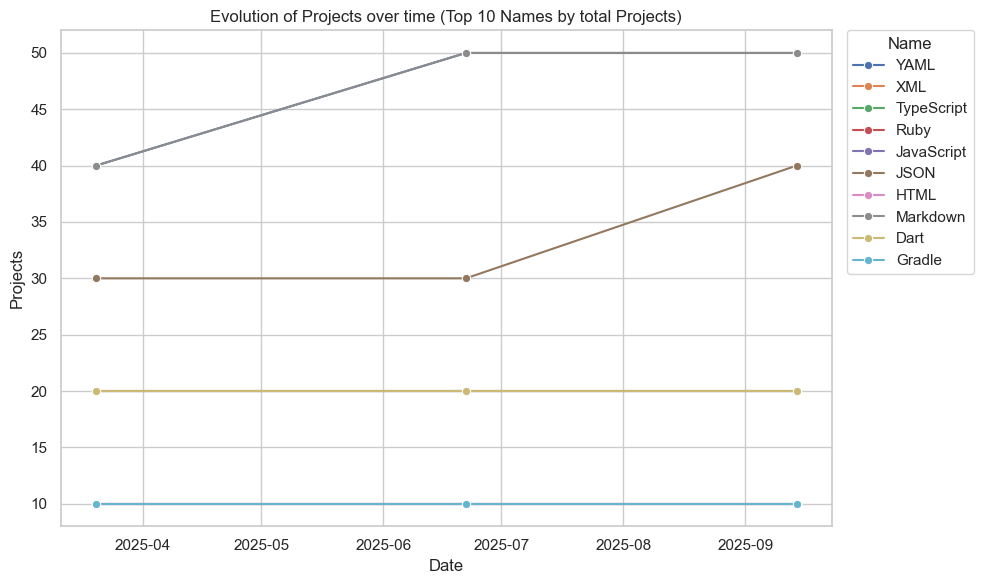

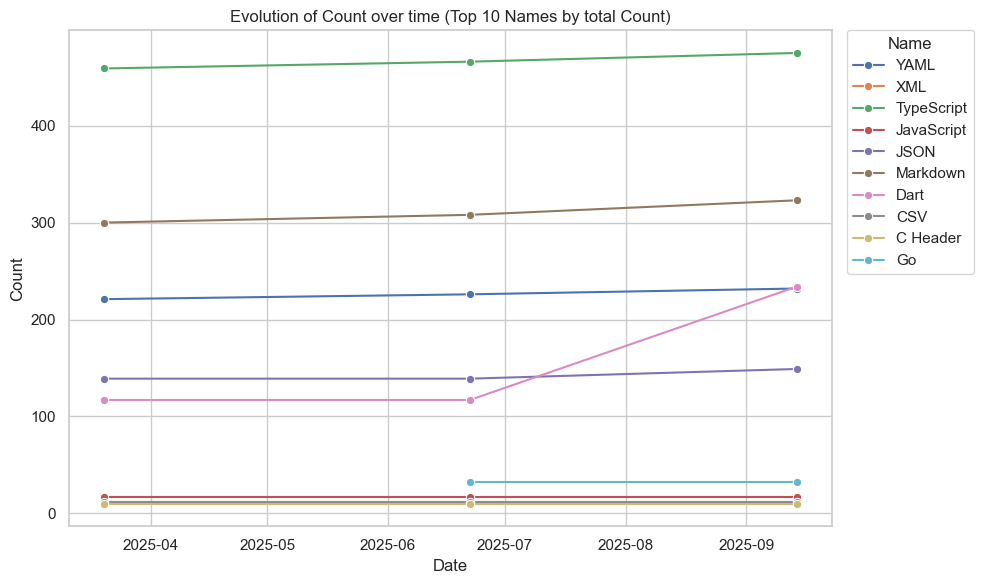

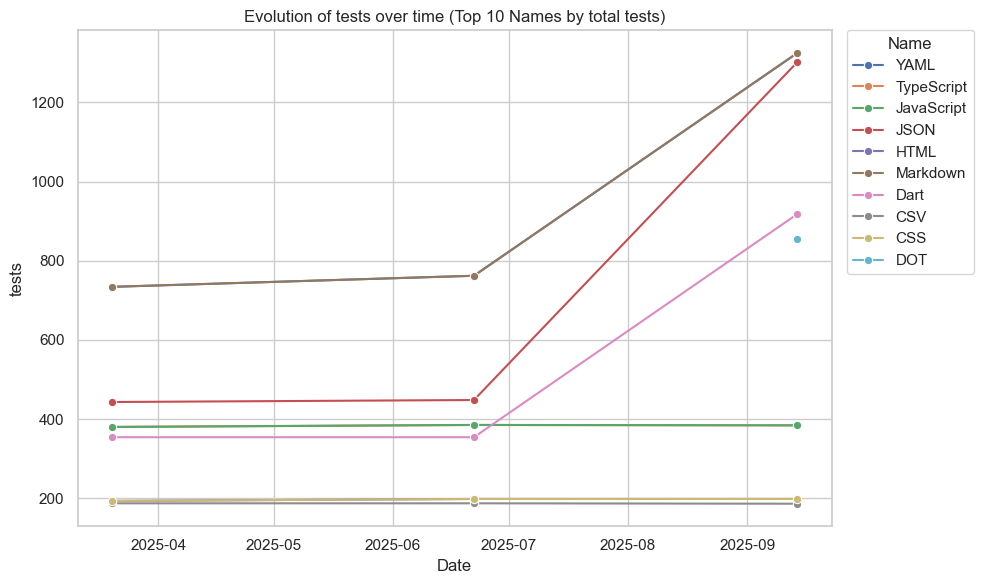

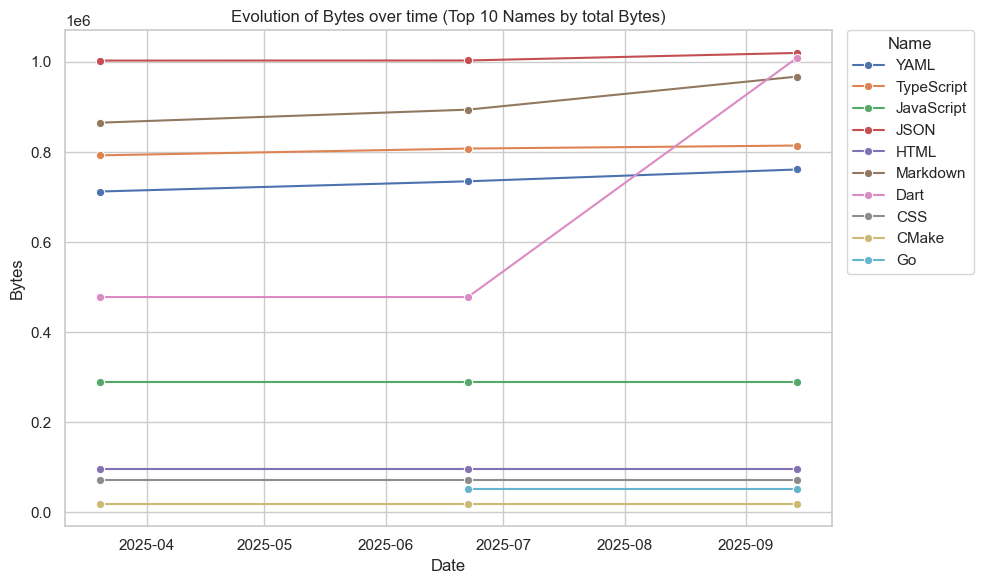

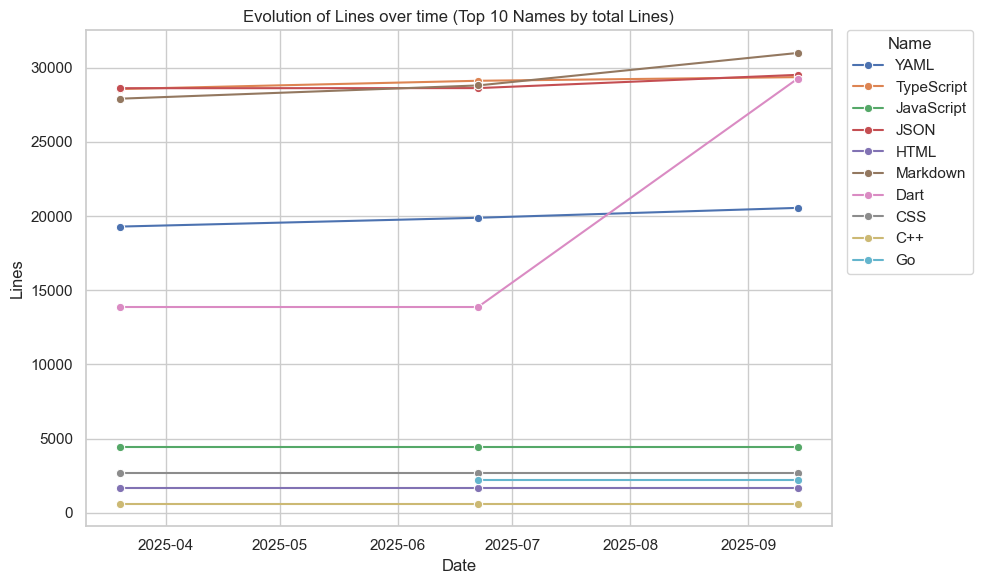

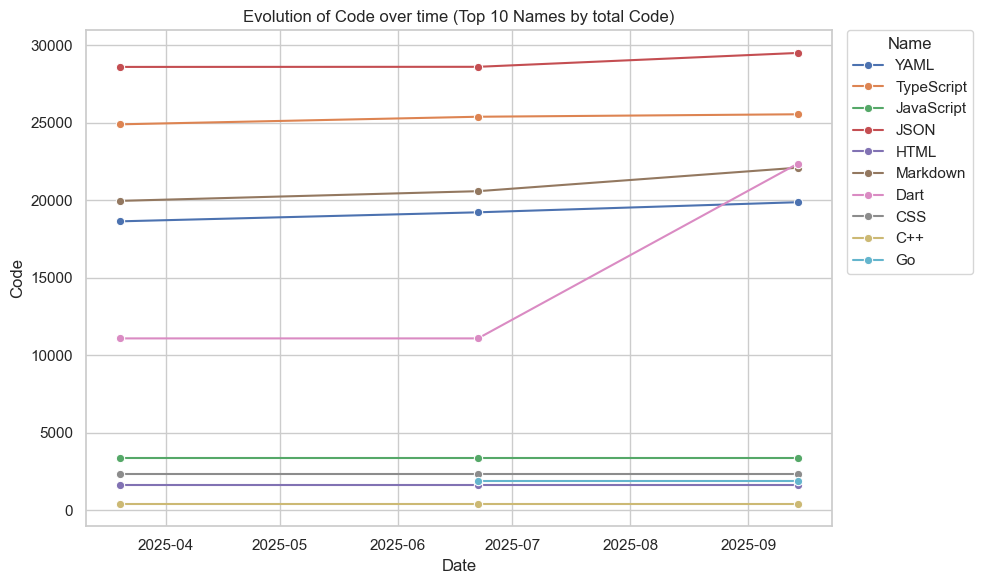

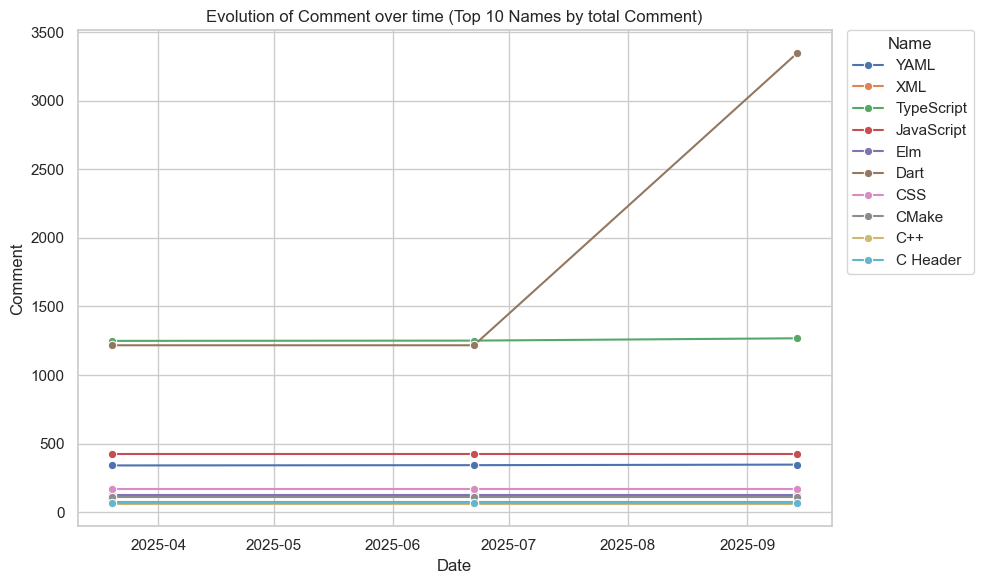

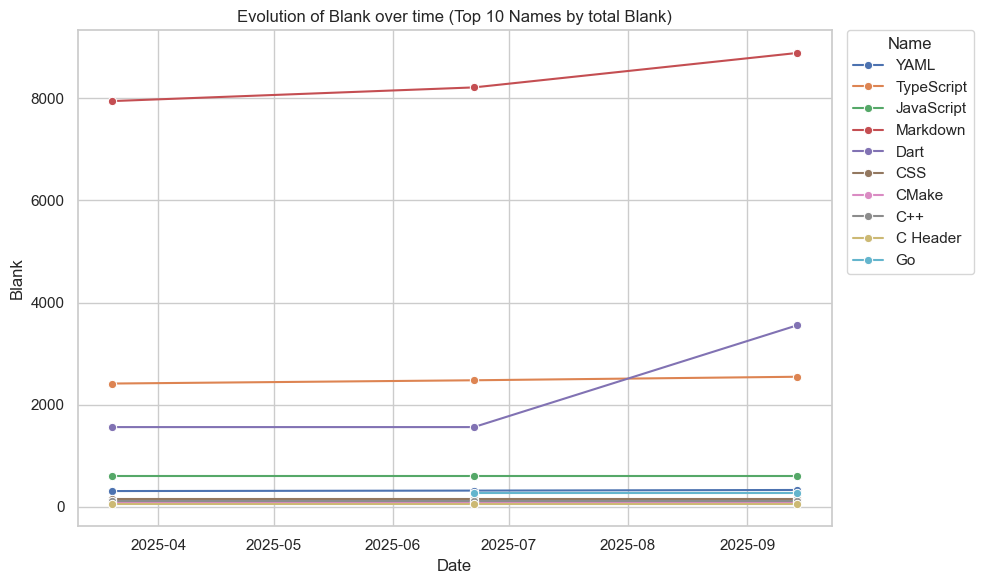

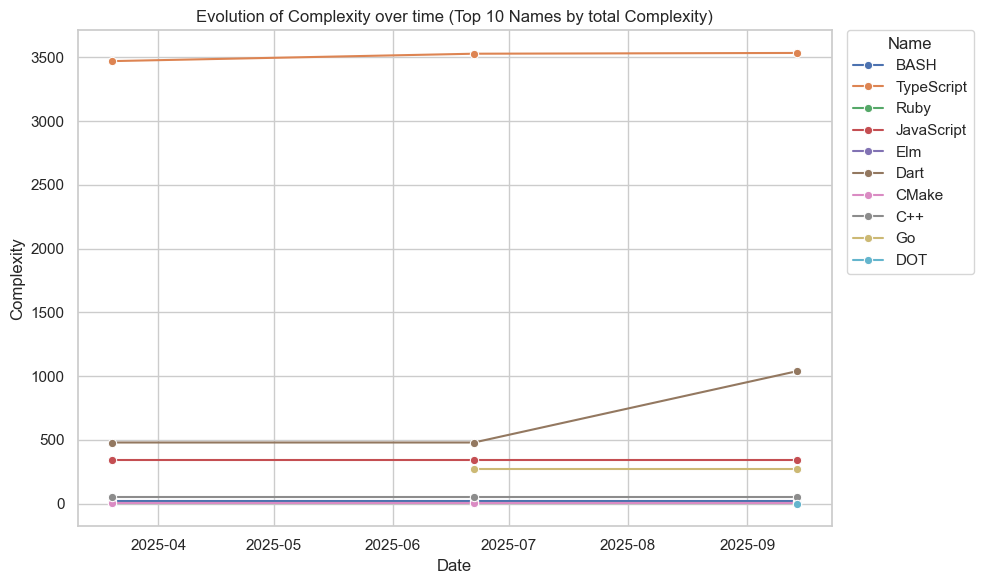

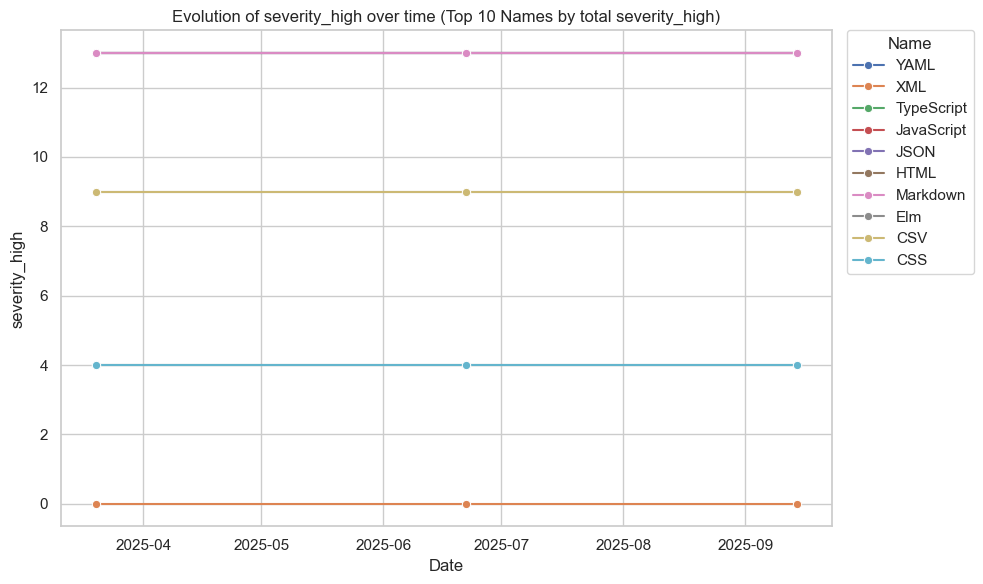

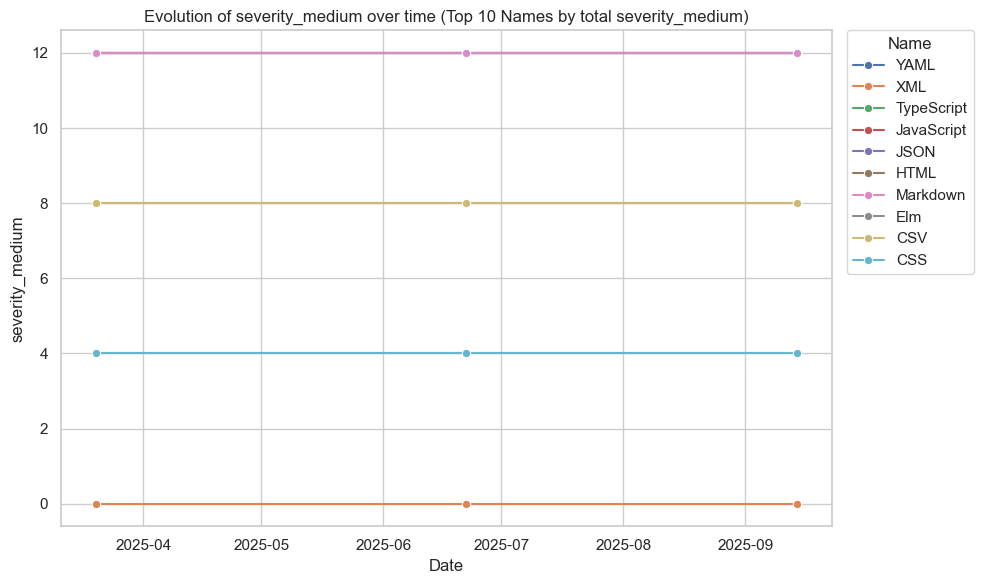

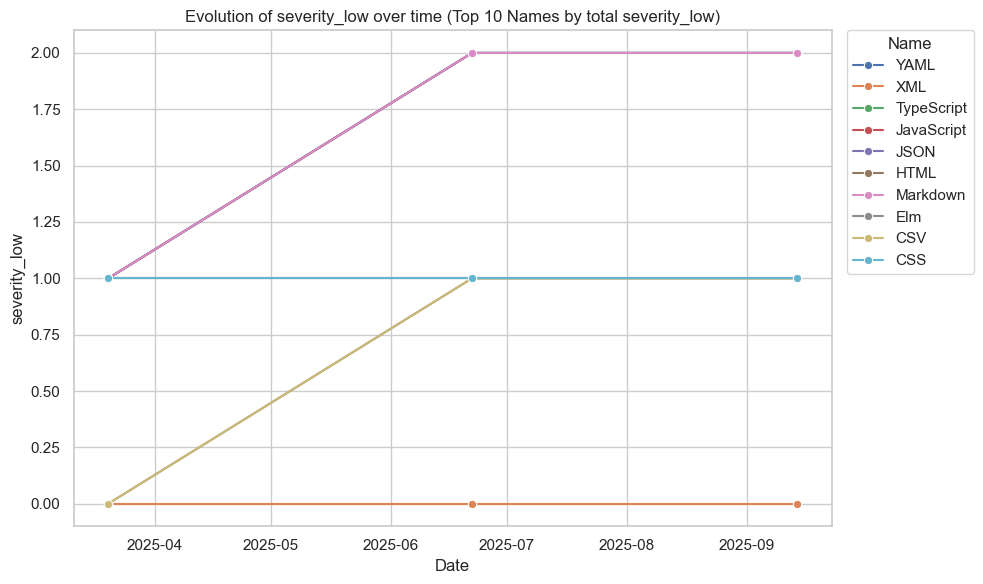

In [1]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
file_pattern = "data/*.json"
top_k_names = 10
candidate_metrics = [
    "Projects", "Count", "tests",
    "Bytes", "Lines", "Code", "Comment", "Blank",
    "Complexity",
    "severity_high", "severity_medium", "severity_low"
]
figure_size = (10, 6)

# Load
file_paths = sorted(glob.glob(file_pattern))
if not file_paths:
    raise FileNotFoundError(f"No files matched pattern: {file_pattern}")

frames = []
for path in file_paths:
    with open(path, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["source_file"] = path
    frames.append(df)

raw = pd.concat(frames, ignore_index=True)

# Parse dates and keep only relevant columns
raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce")
raw = raw.dropna(subset=["Date"])

# Keep only metrics that exist in the files
metrics = [m for m in candidate_metrics if m in raw.columns]

# Coerce metric columns to numeric (robust to occasional non-numeric entries)
for m in metrics:
    raw[m] = pd.to_numeric(raw[m], errors="coerce")

# Aggregate to one row per Date–Name in case some files repeat entries
grouped = (
    raw.groupby(["Date", "Name"], as_index=False)[metrics]
       .sum(min_count=1)  # preserves NaN if all are NaN
       .sort_values("Date")
)

# Plot settings
sns.set_theme(style="whitegrid")

# Output directory for optional saving (disabled by default)
save_figures = False
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)

for metric in metrics:
    # Identify top-K names by total over time for this metric
    totals = (
        grouped.groupby("Name", as_index=True)[metric]
               .sum(min_count=1)
               .sort_values(ascending=False)
               .head(top_k_names)
    )
    top_names = totals.index.tolist()

    data_plot = grouped[grouped["Name"].isin(top_names)].copy()
    # Handle purely missing series
    if data_plot[metric].notna().sum() == 0:
        print(f"Skipping {metric}: no non-missing values.")
        continue

    plt.figure(figsize=figure_size)
    ax = sns.lineplot(
        data=data_plot,
        x="Date",
        y=metric,
        hue="Name",
        marker="o"
    )
    ax.set_title(f"Evolution of {metric} over time (Top {top_k_names} Names by total {metric})")
    ax.set_xlabel("Date")
    ax.set_ylabel(metric)
    ax.legend(title="Name", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()

    if save_figures:
        fname = output_dir / f"{metric.replace(' ', '_').lower()}_top{top_k_names}.png"
        plt.savefig(fname, dpi=150)
    plt.show()
